# Stanford CME 241 (Winter 2024) - Assignment 4

**Due: Feb 5 @ 11:59pm Pacific Time on Gradescope.**

Assignment instructions:
- **Please solve questions 1 and 2, and choose one of questions 3 or 4.**
- Empty code blocks are for your use. Feel free to create more under each section as needed.

Submission instructions:
- When complete, fill out your publicly available GitHub repo file URL and group members below, then export or print this .ipynb file to PDF and upload the PDF to Gradescope.

*Link to this ipynb file in your public GitHub repo (replace below URL with yours):* 

https://github.com/my-username/my-repo/assignment-file-name.ipynb

*Group members (replace below names with people in your group):* 
- Person 1
- Person 2
- Person 3

## Imports

## Question 1
Implement *Approximate Policy Iteration*, generalization of the tabular
Policy Iteration we covered in the previous class. In order to implement
Approximate Policy Iteration, first review the interface and
implementation of *Approximate Policy Evaluation* and *Approximate Value
Iteration* (in file
[rl/approximate_dynamic_programming.py](https://github.com/TikhonJelvis/RL-book/blob/master/rl/approximate_dynamic_programming.py)),
then design the interface of *Approximate Policy Iteration* to be the
same as that of *Approximate Value Iteration*. Note that your
implementation of *Approximate Policy Iteration* would need to invoke
*Approximate Policy Evaluation* since Policy Evaluation is a component
of Policy Iteration. Test that your implementation is correct in two
ways:

-   Ensure that *Approximate Policy Iteration* gives the same Optimal
    Value Function/Optimal Policy as that obtained by *Approximate Value
    Iteration*.

-   Ensure that *Approximate Policy Iteration* produces the same result
    as our prior implementation of Policy Iteration (in file
    [rl/dynamic_programming.py](https://github.com/TikhonJelvis/RL-book/blob/master/rl/dynamic_programming.py)).
    For this you need to pass to your implementation of *Approximate
    Policy Iteration* a `FiniteMarkovDecisionProcess` input and a
    `Tabular` instance for the `FunctionApprox` input.

In [53]:
from typing import Iterator, Tuple, TypeVar, Sequence, List
from operator import itemgetter
import numpy as np

from rl.distribution import Distribution
from rl.function_approx import FunctionApprox
from rl.iterate import iterate
from rl.markov_process import (FiniteMarkovRewardProcess, MarkovRewardProcess,
                               RewardTransition, NonTerminal, State)
from rl.markov_decision_process import (FiniteMarkovDecisionProcess,
                                        MarkovDecisionProcess,
                                        StateActionMapping)
from rl.policy import DeterministicPolicy

S = TypeVar('S')
A = TypeVar('A')

ValueFunctionApprox = FunctionApprox[NonTerminal[S]]
QValueFunctionApprox = FunctionApprox[Tuple[NonTerminal[S], A]]
NTStateDistribution = Distribution[NonTerminal[S]]


def approximate_policy_evaluation(
    mdp: MarkovDecisionProcess[S, A],
    γ: float,
    policy: DeterministicPolicy[S, A],
    approx_0: ValueFunctionApprox[S],
    non_terminal_states_distribution: NTStateDistribution[S],
    num_state_samples: int,
    error_tolerance: float
) -> ValueFunctionApprox[S]:
    '''Approximate policy evaluation for a given Markov Decision Process
    and policy using the given FunctionApprox to approximate the value
    function.

    '''
    def update(v: ValueFunctionApprox[S]) -> ValueFunctionApprox[S]:
        def return_(s_r: Tuple[State[S], float]) -> float:
            s1, r = s_r
            return r + γ * v.evaluate([s1])[0]

        return v.update(
            [(s, mdp.step(s, policy.act(s)).expectation(return_))
             for s in non_terminal_states_distribution.sample_n(num_state_samples)],
            error_tolerance
        )

    return iterate(update, approx_0)


def approximate_policy_iteration(
    mdp: MarkovDecisionProcess[S, A],
    γ: float,
    approx_0: ValueFunctionApprox[S],
    non_terminal_states_distribution: NTStateDistribution[S],
    num_state_samples: int,
    error_tolerance: float
) -> Iterator[Tuple[ValueFunctionApprox[S], DeterministicPolicy[S, A]]]:
    '''Approximate Policy Iteration for a given Markov Decision Process
    using the given FunctionApprox to approximate the value function.

    '''
    policy: DeterministicPolicy[S, A] = DeterministicPolicy(
        lambda s: max(
            ((mdp.step(NonTerminal(s), a).expectation(
                lambda s_r: s_r[1] + γ * approx_0.evaluate([s_r[0]])[0]), a)
             for a in mdp.actions(NonTerminal(s))),
            key=itemgetter(0)
        )[1]
    )

    while True:
        vf = approximate_policy_evaluation(
            mdp, γ, policy, approx_0,
            non_terminal_states_distribution, num_state_samples, error_tolerance
        )
        yield vf, policy

        # Policy improvement
        policy_stable = True
        for s in mdp.non_terminal_states:
            old_action = policy.act(s)
            new_action = max(
                ((mdp.step(NonTerminal(s), a).expectation(
                    lambda s_r: s_r[1] + γ * vf.evaluate([s_r[0]])[0]), a)
                 for a in mdp.actions(NonTerminal(s))),
                key=itemgetter(0)
            )[1]
            if old_action != new_action:
                policy_stable = False
                policy = policy.update({s: new_action})
        if policy_stable:
            break
            
            
            
# Define the state transition probabilities
transition_mapping = {
    'S1': {
        'A1': StateReward('S1', 1.0),
        'A2': StateReward('S2', 2.0)
    },
    'S2': {
        'A1': StateReward('S1', 0.0),
        'A2': StateReward('S2', -1.0)
    }
}

# Define the rewards
reward_mapping = {
    'S1': {
        'A1': 1.0,
        'A2': 2.0
    },
    'S2': {
        'A1': 0.0,
        'A2': -1.0
    }
}


mdp = FiniteMarkovDecisionProcess(transition_mapping, reward_mapping)

# sample policy
policy_mapping = {
    'S1': {'A1': 0.5, 'A2': 0.5},
    'S2': {'A1': 0.3, 'A2': 0.7}
}
policy = FinitePolicy(policy_mapping)


tabular_approx = Tabular()

# example
gamma = 0.9
num_state_samples = 1000
error_tolerance = 0.01



## Question 2
Assume the Utility function is $U(x) = x - \frac {\alpha x^2} 2$.
Assuming $x \sim \mathcal{N}(\mu, \sigma^2)$, calculate:

-   Expected Utility $\mathbb{E}[U(x)]$

-   Certainty-Equivalent Value $x_{CE}$

-   Absolute Risk-Premium $\pi_A$


Assume you have a million dollars to invest for a year and you are
allowed to invest $z$ dollars in a risky asset whose annual return on
investment is $\mathcal{N}(\mu, \sigma^2)$ and the remaining (a million
minus $z$ dollars) would need to be invested in a riskless asset with
fixed annual return on investment of $r$. You are not allowed to adjust
the quantities invested in the risky and riskless assets after your
initial investment decision at time $t=0$ (static asset allocation
problem). If your risk-aversion is based on this Utility function, how
much would you invest in the risky asset? In other words, what is the
optimal value for $z$, given your level of risk-aversion (determined by
a fixed value of $\alpha$)?

Plot how the optimal value of $z$ varies with $\alpha$.

$\mathbb{E}[U(x)] = \mathbb{E}[x - \frac{\alpha x^{2}}{2}]$.
Using linearity of expectation, and the fact that for a normal RV, $\mathbb{E}[x] = \mu$ and $\mathbb{E}[x^{2}] = Var(x) + (\mathbb{E}[x])^2 = \sigma ^{2} + \mu ^ {2}$

$ = \mathbb{E}[x] - \frac{\alpha}{2} \mathbb{E}[x^{2}] = \mu - \frac{\alpha}{2} (\sigma ^{2} + \mu ^ {2})$

Hence, the expected utility is $\mathbb{E}[U(x)] = \mu - \frac{\alpha}{2}\sigma ^{2} - \frac{\alpha}{2}\mu ^{2}$.

To find the Certain Equivalent, $x_{CE} =  U^{-1}(\mathbb{E}[U(x)]) = U^{-1}(\mu - \frac{\alpha}{2}\sigma ^{2} - \frac{\alpha}{2}\mu ^{2})$. 

To find the inverse utility function, we can use simple algebra:
To find the inverse of the function $U(x) = x - \frac{\alpha}{2}x^2 $, we need to solve for $x$ in terms of $U(x)$. 

We can solve for $ U^{-1}(x) $ as follows:

$ x = U^{-1}(U(x)) = U^{-1}\left(x - \frac{1}{2}ax^2\right) $


$U^{-1}(x) = \frac{1 + \sqrt{1 - 2\alpha x}}{\alpha}$

We now plug in $x = \mathbb{E}[U(x)]$ and obtain

$x_{CE} = U^{-1}(\mu - \frac{\alpha}{2}\sigma ^{2} - \frac{\alpha}{2}\mu ^{2})$

$ = \frac{1 + \sqrt{1 - 2\alpha(\mu - \frac{\alpha}{2}\sigma ^{2} - \frac{\alpha}{2}\mu ^{2})}}{\alpha} = \frac{ 1 + \sqrt{1 - 2\alpha \mu + \alpha^{2} \sigma^{2} + \alpha^{2} \mu^{2}}}{\alpha} $

To find the absolute risk premia $\pi_A = \mathbb{E}[U(x)] - x_{CE} = \mu - \frac{\alpha}{2}\sigma ^{2} - \frac{\alpha}{2}\mu ^{2}- \frac{ 1 + \sqrt{1 - 2\alpha \mu + \alpha^{2} \sigma^{2} + \alpha^{2} \mu^{2}}}{\alpha}$.

For the second part, let our wealth level at the end of the year be $W = zx + (1 - z)(1 + r)$, where r is the interest rate over a year and x is our risky return with normal distribution on $\mu, \sigma^{2}$. Note for simplicity, this will give us the investment level based on one dollar which can be extrapolated as a proportion of one million.

We want to maximimze our utility of wealth with respect to z, the amount we invest in the risky asset.

Our portfolio wealth in one year is: 

$W ∼ N(1+r+z(μ−r),z^2σ^2)$

As a function of W, $U(W) = W - \frac{\alpha}{2} W^2$

Our goal is to maximize the expectation of this w.r.t z, the proportion of our portfolio we invest in the risky asset:

$\mathbb{E}[U(W)] = \mathbb{E}[W] - \frac{\alpha}{2}\mathbb{E}[W^2]$ via linearity of expectation

$\mathbb{E}[W] = 1+r+z(μ−r), \mathbb{E}[W^2] = (1+r+z(μ−r))^2 + z^2σ^2, $

Hence our goal is:

$\max \mathbb{E}[U(W)] = \max {1+r+z(μ−r) - \frac{\alpha}{2} (1+r+z(μ−r))^2 + z^2σ^2 }$

We take a deritive w.r.t z, and set equal to zero to obtain the equation:

$(μ−r) - \alpha (1 + r + z(μ−r))*(μ−r) - \alpha z \sigma^2 = 0$

Using algebra, we obtain,

$z = \frac{(1 - \alpha - \alpha r)(μ−r)}{\alpha ((μ−r)^2 + \sigma^2)}$.  Since U is a concave function, its critical point must achieve a maximum and hence $1000000z$ is the optimal allocation, and $1000000(1-z)$ is our allocation in the riskless asset. Below is the plot for certain choices of the mean and variance of the risky asset with the risk free rate, where z is the allocation proportion of a single dollar.




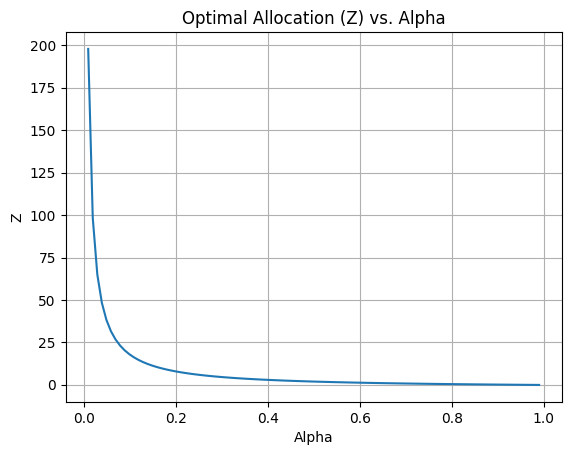

In [29]:
import numpy as np
import matplotlib.pyplot as plt

# Define the function for z
def calculate_z(alpha, r, mu, sigma):
    numerator = (1 - alpha - alpha * r) * (mu - r)
    denominator = alpha * ((mu - r)**2 + sigma**2)
    return numerator / denominator

# Define the parameters
r = 0.05  # risk-free rate
mu = 0.1  # expected return of the risky asset
sigma = 0.15  # standard deviation of the risky asset returns

# Generate values of alpha
alphas = np.linspace(0.01, 0.99, 100)  # adjust the range as needed

# Calculate corresponding values of z
zs = calculate_z(alphas, r, mu, sigma)

# Plot z against alpha
plt.plot(alphas, zs)
plt.xlabel('Alpha')
plt.ylabel('Z')
plt.title('Optimal Allocation (Z) vs. Alpha')
plt.grid(True)
plt.show()

## Question 3

Assume you are playing a casino game where at every turn, if you bet a
quantity $x$, you will be returned $x \cdot (1 + \alpha)$ with
probability $p$ and returned $x \cdot (1 - \beta)$ with probability
$q = 1 - p$ for $\alpha, \beta \in \mathbb{R}^+$ (i.e., the return on
bet is $\alpha$ with probability $p$ and $-\beta$ with probability
$q = 1-p$) . The problem is to identify a betting strategy that will
maximize one's expected wealth over the long run. The optimal solution
to this problem is known as the Kelly criterion, which involves betting
a constant fraction of one's wealth at each turn (let us denote this
optimal fraction as $f^*$).

It is known that the Kelly criterion (formula for $f^*$) is equivalent
to maximizing the Expected Utility of Wealth after a single bet, with
the Utility function defined as: $U(W) = \log(W)$. Denote your wealth
before placing the single bet as $W_0$. Let $f$ be the fraction (to be
solved for) of $W_0$ that you will bet. Therefore, your bet is
$f \cdot W_0$.

-   Write down the two outcomes for wealth $W$ at the end of your single
    bet of $f \cdot W_0$.

-   Write down the two outcomes for $\log$ (Utility) of $W$.

-   Write down $\mathbb{E}[\log(W)]$.

-   Take the derivative of $\mathbb{E}[\log(W)]$ with respect to $f$.

-   Set this derivative to 0 to solve for $f^*$. Verify that this is
    indeed a maxima by evaluating the second derivative at $f^*$. This
    formula for $f^*$ is known as the Kelly Criterion.

-   Convince yourself that this formula for $f^*$ makes intuitive sense
    (in terms of it's dependency on $\alpha$, $\beta$ and $p$).


1. Two outcomes for wealth $W$:
   After the single bet of $(f \cdot W_0)$:
   If the bet wins with probability $p$, the wealth becomes $W_1 = W_0 f \cdot (1 + \alpha) \cdot +  (1-f)W_0 = W_0(1 + f\alpha)$, where the second terms represents the amount that wasn't ber and hence we keep. Similarly, 
   If the bet loses with probability $q = 1 - p $, the wealth becomes $W_2 = W_0 f \cdot (1 - \beta) \cdot + (1-f)W_0 = W_0(1 - f\beta)$ .
   

2. Two outcomes for $\log$ (Utility) of $W$:
   Using the utility function $U(W) = \log(W)$, the two outcomes for the utility of wealth are:
   If the bet wins, the utility becomes $log(W_1) = \log(W_0(1 + f\alpha))$.
   If the bet loses, the utility becomes $log(W_2) = \log(W_0(1 - f\beta))$.


3. Expected Utility $\mathbb{E}[\log(W)]$:
   The expected utility is calculated by taking the average of the utilities of the two outcomes, weighted by their probabilities:
   
   $\mathbb{E}[\log(W)] = p \cdot \log(W_1) + q \cdot \log(W_2)$
   
   $= p \cdot \log(W_0(1 + f\alpha)) + (1-p) \cdot \log(W_0(1 - f\beta)) $

   
5. Derivative of $\mathbb{E}[\log(W)]$ with respect to $f$:
   Let's denote this derivative as $ \frac{d}{df} \mathbb{E}[\log(W)] $.

   $ \frac{d}{df} \mathbb{E}[\log(W)] = p\frac{\alpha}{(1 + f\alpha)} - q\frac{\beta}{(1 - f\beta)}$

6. Setting the derivative to 0 to solve for $f^*$:
   $p\frac{\alpha}{(1 + f\alpha)} - q\frac{\beta}{(1 - f\beta)} = 0$

   $ \frac{p\alpha}{(1 + f\alpha)} = \frac{q\beta}{(1 - f\beta)} --->$  $f^* = \frac{p}{\alpha} - \frac{q}{\beta}$

7. Verifying the maximum:
   We verify that the solution $f^*$ is indeed a maximum by evaluating the second derivative of $\mathbb{E}[\log(W)]$ at $f^*$:

   $\frac{d^2}{df^2} \mathbb{E}[\log(W)] = \frac{-fp\alpha}{(1 + f\alpha)^{2}} + {\frac{-fq\beta}{(1 - f\beta)^{2}}}$

   Since $\alpha, \beta, p, q, f$ are strictly positive, this implies that both terms here must be negative everywhere, as the numerators are always negative and the denominators (which are squared are always positive.  Hence,$\frac{d^2}{df^2} \mathbb{E}[\log(W)] > 0$ when evaluated anywhere (including at the local maximum we found, and our solution $f^*$ is indeed the maximum.
   

8. Intuition behind $f^*$:
   using the fact we derived that $f^* = \frac{p}{\alpha} - \frac{q}{\beta}$, the fraction of money we bet is directly proportion to the ratio of the probability of winning to the return of a win.  Essentially, this represents the "bang for our buck", and is indicative of how consumers are looking for the fairest odds possible.  Similarly, the fraction of wealth is inversely related to the ratio of probability of losing to the losing return.  We would expect that if the probability of losing is really high, then we might not want to take this bet, as is indicated in this solution.  

## Question 4

Derive the solution to Merton's Portfolio problem for the case of the
$\log(\cdot)$ Utility function. Note that the derivation in the textbook
is for CRRA Utility function with $\gamma \neq 1$ and the case of the
$\log(\cdot)$ Utility function was left as an exercise to the reader.